# Practical survey of language detection algorithms in Python

In this article I test several algorithms and libraries for language detection in Python. You can see similar article in https://tech.people-doc.com/how-to-detect-western-language-with-python.html, but in my case I have some special needs:

- I need detect the language of blog and news titles: not the complete text , only the title
- The sentences will be in Spanish, English and Galician.


The original article test the algoriths with sentences extracted from Genesis corpus. In this case the sentences are very similar, it doesn't include several languages in the same sentence, the vocabulary is limited and there aren't a Galician version of Genesis corpus available. 

This study is part of a larger project, so I create a small test case with titles extracted from the real case. 

The Galician is underrepresented int the test set, but is a similar percentage than the real case. I add some Portuguese sentences too. This is because Galician and Portuguese are very similar, and is difficult for algorithms tell apart both languages, and there aren't data to train the algorithms for Galician, so the challenge is more interesign.

You can see more info about Galician in https://en.wikipedia.org/wiki/Galician_language

(Note: this code was tested with Python 3.6.4)



This two functions allows save and load models, arrays, etc. to disk, If some process is very time consuming (process a list of words, or generate a statistical mode, for example) we can do the process, save the result and, the next time, load from disk.

In [4]:
import pickle

import  pprint 
pp = pprint.PrettyPrinter(indent=4, width=70, compact=True)


def deserialize_from_disk(filename):
    pp.pprint (f'deserializing from {filename}')
    with open(filename,'rb') as fin:
        tagger = pickle.load(fin)
    return tagger

def serialize_to_disk(filename, tagger):
    pp.pprint (f'serializing to  {filename}')
    with open(filename, 'wb') as fout:
        pickle.dump(tagger, fout)


## Creating the test set

Some libraries works with complete sentences, others with tokens (words), so I created two sets for naive test, and two functions for run the algorithms over the full test set.

In order to install nltk lib run:

```shell
pip install nltk
```
    

In [5]:
# some basic imports, etc.

import nltk
import sys


include_pt=False

iso_to_human = {'un': 'unknow', 'en': 'english', 'es': 'spanish', 'gl': 'galician', }
if (include_pt):
    iso_to_human['pt'] = 'portuguese'
tmp_dir = '/home/xurxo/todo/tmp/'


In [6]:
from nltk import  word_tokenize

# one sentence for each language to test the methods
english_text = '''
Hi! Was wondering if anyone had tips/tricks on how to reset your hook grip between reps. This typically is only an issue for me when I'm doing something like a heavy triple clean. First rep is no problem...no pain, nothing. But I have a hard time holding on to my hook grip with full rotation high
'''
spanish_text = '''
Akira Kurosawa puso su grano de arena para explicar el Japón de la derrota militar en sus filmes de posguerra (Un domingo maravilloso), exploró los códigos del cine negro (El ángel ebrio) y puso en diálogo las historias del Japón feudal con el western (Los siete samuráis) o con la dramaturgia de
'''
galician_text = '''
Os activistas explicaron aos presentes que a reapertura da explotación en Touro “non ten viablidade”. E avisaron da “forte oposición” veciñal á mesma, que soborda a bisbarra e esténdese Ulla abaixo. De feito, as comarcas da Arousa atópanse entre as prinicipais zonas contrarias á mina.
'''
portuguese_text = '''
Uma equipa de especialistas do Porto está a desenvolver um sistema que realiza previsões climáticas "precisas" de curto, médio e longo prazo, baseadas num novo algoritmo, com o intuito de auxiliar empresas e as entidades públicas na tomada de decisão
'''
en_tokens  = [word.lower() for word in word_tokenize(english_text)]
es_tokens  = [word.lower() for word in word_tokenize(spanish_text)]
gl_tokens  = [word.lower() for word in word_tokenize(galician_text)]
pt_tokens  = [word.lower() for word in word_tokenize(portuguese_text)]

Insall pandas with

```shell
pip install pandas
```

In [7]:
import pandas as pd

# load the test set from files

dfs  = []
langs =['english','spanish','galician',]
if (include_pt): langs.append('portuguese')
for lang in langs:
    titles = pd.read_table(f'{lang}_testset.txt',names=['sentences'] )[0:500]
    titles['sentences'] = titles['sentences'].apply(str.lower)
    titles['label'] = lang
    titles['tokens'] = titles['sentences'].apply(str.lower).apply(word_tokenize)
    pp.pprint (f'{lang} -> {titles.shape[0]} sentences')
    dfs.append(titles)

titles_sentences_small = pd.concat([d for d in dfs[0:50]], ignore_index=True)
titles_sentences = pd.concat(dfs, ignore_index=True)




'english -> 500 sentences'
'spanish -> 500 sentences'
'galician -> 500 sentences'


## Accuracy test

Let's create a function to test the algorithms. It apply the algorithm to a data frame and store the accuracy of the result, and the running time. También mostramos una matriz de errores normalizada. El código original está sacado de https://stackoverflow.com/a/29877565


In [8]:
# from nltk.metrics import ConfusionMatrix
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools


times = {}
accuracies = {}
confussion_matrices = {}


def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    
    import matplotlib.pyplot as plt
    plt.imshow(df_confusion, cmap=cmap) # matshow
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    
    fmt = '.2f'
    thresh = df_confusion.max().max() / 2.
    for i, j in itertools.product(range(len(df_confusion.columns)), range(len(df_confusion.index))):
        a = df_confusion.columns[i]
        b = df_confusion.index[j]
        val = df_confusion[a][b]
        plt.text(j, i, format(df_confusion[a][b], fmt),
                 horizontalalignment="center",
                 color="white" if val > thresh else "black")
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
    
def plot_all_confusion_matrix():
    for name, matrix in confussion_matrices.items():
        np.set_printoptions(precision=2)
        plt.figure()
        plot_confusion_matrix(matrix, title=name)
        
        

def plot_all_accuracies():
    for name, matrix in confussion_matrices.items():
        plot_confusion_matrix(matrix, title=name)
        
        
def plot_all_accuracies():
    print_table (accuracies, 'accuracy')
    print()
    print_table (times, 'time')
    
    
def print_table (dictonary, label):
    print ("{:>35}     {:<25}".format('algorithm', label))
    print ("{:>35}     {:<25}".format('----', '----'))
    for k in dictonary:
        print ("{:>35}     {:<25}".format(k, dictonary[k]))
        
def compute_accuracy (df, predictor, columns, verbose, plot_confusion):
    start_time = time.time()
    if len(columns ) ==1:
        df['r_' + predictor.__name__] = df[columns[0]].apply(predictor) 
    else:
        df['r_' + predictor.__name__] = df.loc[:,columns].apply(predictor,  axis=1) 
    
    # time = %timeit -n1 -r1 -p3 -o accuracies [predictor.__name__] = (result == expected).sum() / len(df)
    # times [predictor.__name__] = time.best
    accuracy = (df['r_' + predictor.__name__] == df['label']).sum() / len(df)
    accuracies [predictor.__name__] = accuracy
    stime = (time.time() - start_time)
    times [predictor.__name__] = stime
             
    print (f'{predictor.__name__}     Accuracy: {accuracy}       Time: {stime}')
    if verbose: 
        print_table (accuracies, 'accuracy')
        print()
        print_table (times, 'time')
    
    y_actu = df['label']
    y_pred = df['r_' + predictor.__name__]
    df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False, normalize='index')
    
    # df_confusion = confusion_matrix(y_actu, y_pred)
    confussion_matrices [predictor.__name__] = df_confusion
    if plot_confusion:
        plot_confusion_matrix(df_confusion, title=predictor.__name__)
    
    return accuracy
    
def compute_accuracy_tokens(df, predictor, verbose=False, plot_confusion=True):
    return compute_accuracy(df, predictor, ['tokens'], verbose, plot_confusion)

def compute_accuracy_sentences(df, predictor, verbose=False, plot_confusion=True):
    return compute_accuracy(df, predictor, ['sentences'], verbose, plot_confusion)

# Detecting with NLTK and stopwords

You can see an explanation of this algorithm in http://blog.alejandronolla.com/2013/05/15/detecting-text-language-with-python-and-nltk/. It uses a list of stopwords per objetive language, computing language probability depending on which stopwords are used. The NLTK library have several stopwords lists, but not for Galician. Fortunately, in https://github.com/stopwords-iso/stopwords-gl  there are one. I use it in this test. In https://www.ranks.nl/stopwords there are other, if you want test.

In [9]:
from nltk.corpus import stopwords    
nltk.download('stopwords')


fileids=['spanish','english']
if (include_pt): fileids.append('portuguese')


# Compute per language included in nltk number of unique stopwords
# appearing in analyzed text
nltk_stopwords_sets = { language: list(set(stopwords.words(language))) 
                  for language in fileids} # list of stopwords per language

file = open("resources/galician_stopwords.txt", "r") 
original_galician_stopwords = [l[:-1] for l in file.readlines()]
nltk_stopwords_sets['galician'] = original_galician_stopwords

[nltk_data] Downloading package stopwords to /home/xurxo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import random
def _calculate_languages_ratios(stopwords_sets, tokens, verbose):
    if verbose:
        print ('tokens:')
        pp.pprint (tokens)
    languages_ratios = {}


    # Compute per language included in nltk number of unique stopwords
    # appearing in analyzed text
    for language in stopwords_sets.keys():
        stopwords_set = stopwords_sets[language]
        words_set = set(tokens)
        common_elements = words_set.intersection(stopwords_set)
        if verbose:
            print(f'{language} common words: ')
            pp.pprint( common_elements)
            
        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios


def detect_with_stopwords(stopwords_sets, tokens, verbose=False):
    ratios = _calculate_languages_ratios(stopwords_sets, tokens, verbose)
    m = max(ratios.values())
    return random.choice([k for k, v in ratios.items() if v == m])
    
def detect_nltk_stopwords (tokens):
    return detect_with_stopwords (nltk_stopwords_sets, tokens)




In [11]:
detect_with_stopwords(nltk_stopwords_sets, 'Ou a praia ou vou ao monte'.lower().split(), verbose=True )

tokens:
['ou', 'a', 'praia', 'ou', 'vou', 'ao', 'monte']
spanish common words: 
{'a'}
english common words: 
{'a'}
galician common words: 
{'a', 'ou', 'ao'}


'galician'

In [12]:
print(detect_nltk_stopwords(en_tokens))
print(detect_nltk_stopwords(es_tokens))
print(detect_nltk_stopwords(gl_tokens))
print(detect_nltk_stopwords(pt_tokens))

english
spanish
galician
galician


detect_nltk_stopwords     Accuracy: 0.8446666666666667       Time: 0.09231209754943848


0.8446666666666667

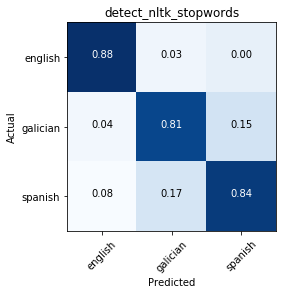

In [13]:
    
compute_accuracy_tokens(titles_sentences, detect_nltk_stopwords)

## Handmade Galician stopwords list
I tried a bigger stopword list for Galician language, based on the 5000 more frequent words (CORGA corpus, by  Centro Ramón Piñeiro). The original list is case sensitive, and too long, so I lowercase it and select the first 400 words, a similar size than other lists. I manually remove common nouns from 


Reference: Centro Ramón Piñeiro para a investigación en humanidades: Corpus de Referencia do Galego Actual (CORGA) [3.0] <http://corpus.cirp.gal/corga/> 

In [243]:
import numpy as np

galician_freq = pd.read_csv('resources/galician_frequency.txt', sep= '\t', index_col=0, decimal=',', thousands='.',
                           dtype={'Unidade':np.str ,
                                  'Coincidencias':np.int ,
                                  'Frecuencia':np.float ,
                                  'Frecuencia acumulada':np.float})



In [244]:
galician_freq.Unidade = galician_freq.Unidade.apply(lambda x: str(x).lower())
grouped = galician_freq.groupby('Unidade')['Coincidencias'].sum().reset_index()
galician_stopwords = [l for l in grouped.sort_values(by='Coincidencias', ascending=False)[:400]['Unidade']]

pp.pprint (galician_stopwords)

[   'de', 'que', 'a', 'e', 'o', 'do', 'da', 'non', 'en', 'os', 'un',
    'se', 'para', 'unha', 'as', 'no', 'por', 'é', 'na', 'como', 'dos',
    'con', 'máis', 'á', 'das', 'ou', 'súa', 'ó', 'seu', 'pero', 'xa',
    'ao', 'nos', 'polo', 'lle', 'era', 'tamén', 'cando', 'pola',
    'todo', 'sen', 'sobre', 'entre', 'son', 'coa', 'co', 'ser', 'hai',
    'foi', 'eu', 'dun', 'aínda', 'moi', 'nas', 'me', 'está', 'así',
    'ben', 'anos', 'el', 'seus', 'mesmo', 'porque', 'dunha', 'só',
    'este', 'ás', 'ten', 'esta', 'onde', 'nun', 'tempo', 'galicia',
    'nin', 'agora', 'coma', 'si', 'quen', 'ata', 'desde', 'dous',
    'vez', 'sempre', 'iso', 'día', 'súas', 'parte', 'todos',
    'segundo', 'nada', 'pode', 'vida', 'cada', 'despois', 'ós',
    'facer', 'estaba', 'tan', 'nunha', 'outra', 'algo', 'casa',
    'tanto', 'ela', 'tiña', 'onte', 'ano', 'cara', 'mais', 'contra',
    'logo', 'mundo', 'moito', 'meu', 'home', 'cos', 'pois', 'antes',
    'pouco', 'outro', 'menos', 'miña', 'tres', 'caso', 'va

The contains nouns and adjetives, so I manually edited it and create a personalized stopword list.

In [64]:
galician_stopwords = ['de', 'que', 'a', 'e', 'o', 'do', 'da', 'non', 'en', 'os', 'un', 'se', 'para', 'unha', 'as',
                      'no', 'por', 'é', 'na', 'como', 'dos', 'con', 'máis', 'á', 'das', 'ou', 'súa', 'ó', 'seu', 
                      'pero', 'xa', 'ao', 'nos', 'polo', 'lle', 'era', 'tamén', 'cando', 'pola', 'todo', 'sen', 
                      'sobre', 'entre', 'son', 'coa', 'co', 'ser', 'hai', 'foi', 'eu', 'dun', 'aínda', 'moi', 
                      'nas', 'me', 'está', 'así', 'ben', 'el', 'seus', 'mesmo', 'porque', 'dunha', 'só', 'este',
                      'ás', 'ten', 'esta', 'onde', 'nun', 'nin', 'coma', 'si', 'quen', 'ata', 'desde', 'sempre',
                      'iso', 'súas', 'parte', 'todos', 'segundo', 'nada', 'pode', 'cada', 'despois', 'ós', 'facer', 
                      'estaba', 'tan', 'nunha', 'outra', 'algo', 'tanto', 'ela', 'tiña', 'mais', 'contra', 'logo',
                      'moito', 'meu', 'cos', 'pois', 'antes', 'pouco', 'outro', 'menos', 'miña', 'vai', 'outros', 
                      'aos', 'ti', 'cun', 'ver', 'ter', 'nunca', 'dúas', 'lugar', 'ademais', 'aquí', 'mellor', 'dixo', 
                      'mentres', 'durante', 'toda', 'primeira', 'días', 'alí', 'había', 'esa', 'ese', 'min', 'polos', 
                      'están', 'uns', 'dicir', 'cunha', 'isto', 'noite', 'coas', 'senón', 'deste', 'veces', 'tal', 
                      'dende', 'case', 'neste', 'maior', 'teñen', 'eles', 'outras', 'xeral', 'calquera', 'nós', 'polas',
                      'foron', 'lles', 'forma', 'conta', 'mesma', 'nosa', 'dentro', 'moitos', 'sexa', 'aquel', 'sei',
                      'eran', 'todas', 'desta', 'gran', 'fai', 'ante', 'será', 'estes', 'estar', 'ninguén', 'aquela',
                      'noso', 'baixo', 'estas', 'dar', 'poden', 'entón', 'fixo', 'moitas', 'mal', 'cultura', 'teño',
                      'che', 'ía', 'debe', 'ir', 'unhas', 'grandes', 'di', 'mañá', 'podía', 'algúns', 'sería', 'fóra',
                      'ningún', 'diante', 'del', 'te', 'fose', 'través', 'fora', 'saber', 'la', 'bo', 'cal', 'tampouco',
                      'temos', 'algún', 'tivo', 'sabe', 'nesta', 'propio', 'pra', 'quere', 'van', 'tódolos', 'podería',
                      'vostede', 'ca', 'estou', 'partir', 'ningunha', 'estaban', 'sendo', 'cabo', 'algunha']


In [65]:

glhandmade_stopwords_sets = dict(nltk_stopwords_sets)
glhandmade_stopwords_sets['galician']={l for l in galician_stopwords}



detect_glhandmade_stopwords     Accuracy: 0.8486666666666667       Time: 0.0975649356842041


0.8486666666666667

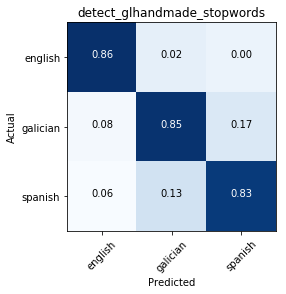

In [66]:

def detect_glhandmade_stopwords (tokens):
    return detect_with_stopwords (glhandmade_stopwords_sets, tokens)


compute_accuracy_tokens(titles_sentences, detect_glhandmade_stopwords)

## Delete common words from lists

What about remove words presents in serveral languages (i.e. 'me','a', 'do', ...)?

In [249]:
from collections import Counter
if (include_pt):
    c = Counter()
    for sw in ['galician','portuguese']: #nltk_stopwords_sets:
        c.update(nltk_stopwords_sets[sw])
    duplicated = [w for w in c if c[w]>1]

    unique_stopwords_sets = dict(nltk_stopwords_sets)
    for sw in  unique_stopwords_sets:
        unique_stopwords_sets[sw]=list(set(unique_stopwords_sets[sw])-set(duplicated))


    def detect_unique_stopwords (tokens):
        return detect_with_stopwords (unique_stopwords_sets, tokens)


    compute_accuracy_tokens(titles_sentences, detect_unique_stopwords)


## stopwords, other implementation

https://tech.people-doc.com/how-to-detect-western-language-with-python.html

We first create a dictionary of stop words per language. It must be noted that this dictionnary includes languages which are not present in the genesis corpus, such as Norwegian or Danish. This ensures a fair comparison between custom solutions and external libraries (which have no restriction on which languages might be present).


In [250]:


from nltk.corpus import stopwords
from collections import defaultdict
import random
from collections import defaultdict, Counter

languages = nltk_stopwords_sets.keys()


inverse_stopwords_dict = defaultdict(list) # list of languages per stopword
for l in languages:
    for sw in nltk_stopwords_sets[l]:
        inverse_stopwords_dict[sw].append(l)     
        

def predict_language_naive(tokens, verbose=False): 
    random.seed(0)
    cnt = Counter()
    cnt.update(language
              for word in tokens
              for language in inverse_stopwords_dict.get(word, ()))
    if not cnt:
        return 'unknown'
    if verbose:
        pp.pprint(cnt)
    m = max(cnt.values())
    return random.choice([k for k, v in cnt.items() if v == m])
    

In [251]:
predict_language_naive('o a la playa o al monte'.split(), verbose=True)

Counter({'spanish': 5, 'galician': 4, 'english': 3})


'spanish'

predict_language_naive     Accuracy: 0.8133333333333334       Time: 0.10611081123352051


0.8133333333333334

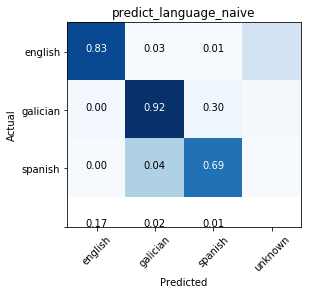

In [252]:
compute_accuracy_tokens(titles_sentences, predict_language_naive)

                          algorithm     accuracy                 
                               ----     ----                     
              detect_nltk_stopwords     0.8426666666666667       
        detect_glhandmade_stopwords     0.8573333333333333       
             predict_language_naive     0.8133333333333334       

                          algorithm     time                     
                               ----     ----                     
              detect_nltk_stopwords     0.0899512767791748       
        detect_glhandmade_stopwords     0.07973051071166992      
             predict_language_naive     0.10611081123352051      


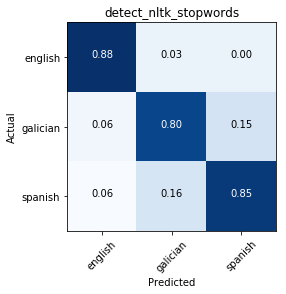

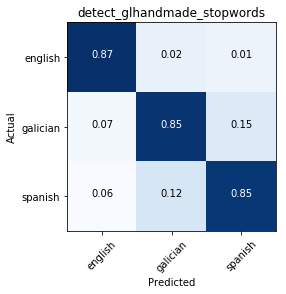

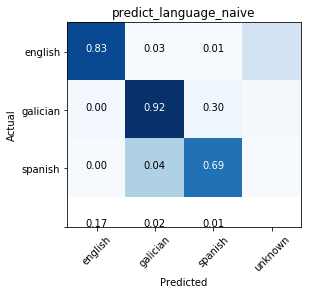

In [253]:
plot_all_accuracies()
plot_all_confusion_matrix()

# Creating corpora
Para algunos algoritmos necesitaremos algunos corpus de diferentes idiomas, compuestos por listas de palabras a partir de diccionarios, textos, etc. Por una parte usaremos algunos de los corpus presentes en NLTK, la librería más usada para iniciarse en el procesamiento de lenguaje natural con Python. Pero también hemos creado dos corpus en gallego para la ocasión, uno a partir de la lista de palabras más usadas en gallego (de nuevo, usando el corpus de Corga) y otro a partir de la Galipedia, la Wikipedia en gallego.

Los corpus de NLTK necesitan algunas transformaciones, puesto que existen terminos completos como 'poner_en_marcha' en el que las palabras vienen separadas originalmente por guiones bajos. Otros corpus tienen palabras en mayúsculas y minúsculas, etc.


To create a galician corpus, we use the wikipedia. You can create a text version with Wikipedia Extractor. Download code  http://medialab.di.unipi.it/wiki/Wikipedia_Extractor . You can make some tweaks like include (or not) titles, sort articles, etc. The process takes 5 min. aprox.

```bash

$ git clone https://github.com/attardi/wikiextractor.git
$ cd wikiextractor
$ wget https://dumps.wikimedia.org/glwiki/latest/glwiki-latest-pages-articles.xml.bz2
$ bzip2 -d glwiki-latest-pages-articles.xml.bz2
$ ./WikiExtractor.py -o . -s --no-templates --min_text_length 150 --filter_disambig_pages -de gallery,timeline,noinclude  glwiki-latest-pages-articles.xml -it abbr,b,big --json -cb 250K
...
INFO: 414064	Pedersöre
INFO: Finished 3-process extraction of 149036 articles in 295.8s (503.8 art/s)

$  find . -name '*bz2' -exec bunzip2 -c {} \; >galician_wikipedia_text.json
$  rm -rf extracted
```


In [14]:
import nltk
import nltk.corpus.europarl_raw
# download corpus
nltk.download('words')
nltk.download('cess_esp')
nltk.download('floresta')
nltk.download('brown')
nltk.download('omw')
nltk.download('europarl_raw')


def clean_tokens(tokens):
    return [token.lower().replace('_', ' ') for token in tokens if token.isalpha()]

def get_corpus (corpus_name, word_list):
    try:
        vocab = deserialize_from_disk(f'{tmp_dir}/corpus/{corpus_name}.corpus')
    except:
        vocab = clean_tokens(w for w in word_list())
        serialize_to_disk(f'{tmp_dir}/corpus/{corpus_name}.corpus', vocab)
    return vocab


def create_gl_corga():
    print('create_gl_corga')
    with open("resources/galician_frequency.txt", "r") as file: 
        return list(l for l in (l.split('\t')[1] for l in file.readlines()[0:10000]))
    
def create_gl_wikipedia ():
    print('create_gl_wikipedia')
    import json

    corpus_gl_wikipedia = []
    file = open("resources/galician_wikipedia_text.json", "r") 
    for l in file.readlines():

        text = json.loads(l)['text']
        # remove title
        text = text.split('\n\n')[1:]
        text = ' '.join(text)
        tokenized_text = nltk.word_tokenize(text)
        corpus_gl_wikipedia.extend(([w for w in tokenized_text ]))
    return corpus_gl_wikipedia



# english
corpus_en_brown = lambda:get_corpus('en_brown',nltk.corpus.brown.words)
corpus_en_wordnet = lambda:get_corpus('en_wordnet', lambda:nltk.corpus.wordnet.words(lang='eng'))
corpus_en_europarl = lambda:get_corpus('en_europarl',nltk.corpus.europarl_raw.__getattribute__('english').words)

#spanish
corpus_sp_cess = lambda:get_corpus('sp_cess',nltk.corpus.cess_esp.words() )
corpus_sp_wordnet = lambda:get_corpus('sp_wordnet',lambda:nltk.corpus.wordnet.words(lang='spa'))
corpus_sp_europarl = lambda:get_corpus('sp_europarl',nltk.corpus.europarl_raw.__getattribute__('spanish').words)

# portuguese
if(include_pt):
    corpus_pt_floresta = lambda:get_corpus('pt_floresta',nltk.corpus.floresta.words )
    corpus_pt_wordnet = lambda:get_corpus('pt_wordnet',lambda:nltk.corpus.wordnet.words(lang='por'))
    corpus_pt_europarl = lambda:get_corpus('pt_europarl',nltk.corpus.europarl_raw.__getattribute__('portuguese').words)

# galician
corpus_gl_wordnet = lambda:get_corpus('gl_wordnet',lambda:nltk.corpus.wordnet.words(lang='glg'))
corpus_gl_corga = lambda:get_corpus('gl_corga', create_gl_corga)
corpus_gl_wikipedia = lambda: get_corpus('gl_wikipedia', create_gl_wikipedia)
    
    
    

    

[nltk_data] Downloading package words to /home/xurxo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package cess_esp to /home/xurxo/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!
[nltk_data] Downloading package floresta to /home/xurxo/nltk_data...
[nltk_data]   Package floresta is already up-to-date!
[nltk_data] Downloading package brown to /home/xurxo/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package omw to /home/xurxo/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package europarl_raw to
[nltk_data]     /home/xurxo/nltk_data...
[nltk_data]   Package europarl_raw is already up-to-date!


In [16]:

all_corpus = { 'english':
              {
                  'en_brown': corpus_en_brown,
                  'en_wordnet': corpus_en_wordnet,                               
                  'en_europarl': corpus_en_europarl,
              },
              'spanish':
              {
                  'sp_cess': corpus_sp_cess, 
                  'sp_wordnet': corpus_sp_wordnet,
                  'sp_europarl': corpus_sp_europarl,
              },
              'galician': 
              {
                  'gl_corga':  corpus_gl_corga, 
                  'gl_wordnetl':corpus_gl_wordnet,
                  'gl_wikipedia': corpus_gl_wikipedia,
              },
             }
        
        
if include_pt:
              all_corpus['portuguese'] =   {
                  'pt_floresta': corpus_pt_floresta, 
                  'pt_wordnet': corpus_pt_wordnet,
                  'pt_europarl': corpus_pt_wordnet,
              }

In [17]:
def get_vocabulary (corpus_name, word_list):
    try:
        vocab = deserialize_from_disk(f'{tmp_dir}/vocabularies/{corpus_name}.vocab')
    except:
        vocab = set(w for w in word_list)
        serialize_to_disk(f'{tmp_dir}/vocabularies/{corpus_name}.vocab', vocab)
    return vocab


all_vocab= {}
for lang, corpus_dict in all_corpus.items():
    all_vocab[lang] = {}
    for corpus_name, corpus in corpus_dict.items():
        all_vocab[lang][corpus_name] =  get_vocabulary(corpus_name, corpus)  

'deserializing from /home/xurxo/todo/tmp//vocabularies/en_brown.vocab'
('deserializing from '
 '/home/xurxo/todo/tmp//vocabularies/en_wordnet.vocab')
('deserializing from '
 '/home/xurxo/todo/tmp//vocabularies/en_europarl.vocab')
'deserializing from /home/xurxo/todo/tmp//vocabularies/sp_cess.vocab'
('deserializing from '
 '/home/xurxo/todo/tmp//vocabularies/sp_wordnet.vocab')
('deserializing from '
 '/home/xurxo/todo/tmp//vocabularies/sp_europarl.vocab')
'deserializing from /home/xurxo/todo/tmp//vocabularies/gl_corga.vocab'
('deserializing from '
 '/home/xurxo/todo/tmp//vocabularies/gl_wordnetl.vocab')
('deserializing from '
 '/home/xurxo/todo/tmp//vocabularies/gl_wikipedia.vocab')


# NLTK: comparing words of text with words of corpus 


The idea is similar to previous part: compare the words in the sentence with a list of words. But in ths case I use a big list of words. Again,for Galician, I use CORGA corpus again


For Spanish I used CESS corpora, present in NLTK library, and for Portuguese we use Floresta corups, in NLTK too. I choose it because it have pt_BR and pt_PT sentences. The alternavie, use Mac_morpho corpus, with pt_BR sentences.

The algorithm is sensible to dictionary. For example, first I tried nltk.corpus.words corpus to try detect English sentences. But, as you can see in https://stackoverflow.com/questions/34756738/missing-words-in-nltk-vocabulary-python
this corpus is big (234377 words), but old (1932): it don't include words like _software_ _monitoring_ _server_ or _recommendations_. So, using this corpus, the algorith returns:

```python
>>> detect_vocab(['recommendations', 'on', 'server', 'monitoring', 'software'])
galician
```

I try others wordlists, including Brow, Floresta, CESS and WordNet corpora, all present in NLTK. For Galician, again, I use the CORGA corpus, processing it because the original is case sensitive. 

I tried all the combinations of wordlists:
English: brown, wordnet
Portuguese: floresta, wordnet
Spanish: cess, wordnet
Galician: wordnet, Corga corpus 


In [18]:

def detect_vocab (tokens, verbose=False, plot_confusion=True):
    ratios={}
    text_vocab = set(w for w in tokens if w.isalpha())
    if verbose: pp.pprint(('vocab: ', text_vocab))
    for v in vocabs:
        if verbose: pp.pprint((v, text_vocab.difference(vocabs[v])))
        ratios[v] = len(text_vocab.difference(vocabs[v]) )
    m = min(ratios.values())
    l = [k for k, v in ratios.items() if v == m]
    # if (len(l)>1): print(tokens,ratios)
    return random.choice([k for k, v in ratios.items() if v == m])

    


In [20]:
from operator import itemgetter
import random
from itertools import product

results = {}
best_combo = []
best_vocab_accuracy = 0
#for english_corpus, english_vocab in all_vocab['english'].items():
#    for spanish_corpus, spanish_vocab in all_vocab['spanish'].items():
#        for galician_corpus, galician_vocab in all_vocab['galician'].items():
#            for portuguese_corpus, portuguese_vocab in all_vocab['portuguese'].items():
combinations =  [[[lang, corpus_name, corpus] for corpus_name, corpus in corpora.items()] for lang, corpora in all_vocab.items()]
for combo in product(*combinations):
    vocabs = {c[0]:c[2] for c in combo}
    
    combo_name = '/'.join([c[1] for c in combo])
    accuracy = compute_accuracy_tokens(titles_sentences, detect_vocab, plot_confusion=False) 
    results[combo_name]  = accuracy
    if (accuracy > best_vocab_accuracy):
        best_vocab_accuracy = accuracy
        best_combo = vocabs
                          
#                vocabs = { 'english': english_vocab, 
#                          'spanish': spanish_vocab, 
#                          'galician': galician_vocab, 
#                          'portuguese': portuguese_vocab, }
#                combo_name = '/'.join([english_corpus,spanish_corpus,galician_corpus,portuguese_corpus])
#                results[combo_name] = compute_accuracy_tokens(titles_sentences, detect_vocab, plot_confusion=False) 
                

sorted(results.items(), key=itemgetter(1))


detect_vocab     Accuracy: 0.912       Time: 0.04762983322143555
detect_vocab     Accuracy: 0.7126666666666667       Time: 0.04503297805786133
detect_vocab     Accuracy: 0.4593333333333333       Time: 0.04741072654724121
detect_vocab     Accuracy: 0.7126666666666667       Time: 0.04391884803771973
detect_vocab     Accuracy: 0.6386666666666667       Time: 0.0452878475189209
detect_vocab     Accuracy: 0.436       Time: 0.04726839065551758
detect_vocab     Accuracy: 0.9073333333333333       Time: 0.044248104095458984
detect_vocab     Accuracy: 0.7073333333333334       Time: 0.04755568504333496
detect_vocab     Accuracy: 0.4633333333333333       Time: 0.04900193214416504
detect_vocab     Accuracy: 0.9146666666666666       Time: 0.044130802154541016
detect_vocab     Accuracy: 0.6986666666666667       Time: 0.045865774154663086
detect_vocab     Accuracy: 0.38133333333333336       Time: 0.04828834533691406
detect_vocab     Accuracy: 0.7006666666666667       Time: 0.04463338851928711
detect_vo

[('en_wordnet/sp_wordnet/gl_wikipedia', 0.3586666666666667),
 ('en_wordnet/sp_europarl/gl_wikipedia', 0.37266666666666665),
 ('en_wordnet/sp_cess/gl_wikipedia', 0.38133333333333336),
 ('en_europarl/sp_wordnet/gl_wikipedia', 0.384),
 ('en_europarl/sp_europarl/gl_wikipedia', 0.4106666666666667),
 ('en_europarl/sp_cess/gl_wikipedia', 0.4226666666666667),
 ('en_brown/sp_wordnet/gl_wikipedia', 0.436),
 ('en_brown/sp_cess/gl_wikipedia', 0.4593333333333333),
 ('en_brown/sp_europarl/gl_wikipedia', 0.4633333333333333),
 ('en_brown/sp_wordnet/gl_wordnetl', 0.6386666666666667),
 ('en_wordnet/sp_wordnet/gl_wordnetl', 0.66),
 ('en_wordnet/sp_europarl/gl_wordnetl', 0.6726666666666666),
 ('en_europarl/sp_wordnet/gl_wordnetl', 0.6946666666666667),
 ('en_wordnet/sp_cess/gl_wordnetl', 0.6986666666666667),
 ('en_wordnet/sp_wordnet/gl_corga', 0.7006666666666667),
 ('en_brown/sp_europarl/gl_wordnetl', 0.7073333333333334),
 ('en_europarl/sp_wordnet/gl_corga', 0.7093333333333334),
 ('en_europarl/sp_cess/gl_w

The combination brown/cess/wordnet_gl corpora combination seems the most promising. Choose wordnet_pt, europarl_pt or floresta doesn't make the difference. There are a lot of difference between worst and best case: gl_wikipedia corpus contais a lot of non-Galician words, so it cause a lot of mistakes.

detect_vocab     Accuracy: 0.914       Time: 0.04699826240539551


0.914

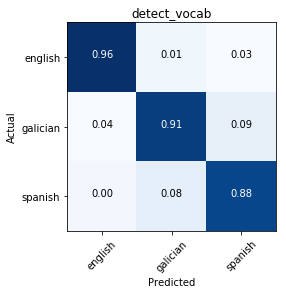

In [23]:

vocabs =  best_combo

compute_accuracy_tokens(titles_sentences, detect_vocab)

# NLTK bigram+unigram taggers

Essentially, I tag each word in the sentence with several taggers, one per language. 'Tag' a sentence means assign  parts of speech to each word: verb, noun, etc. If you tray tag an English sentence with a Spanish tagger, you will obtain a lot of words untagged. So, the result with more tagged word indicate the more  language. 


Alternative 1: Use NLTK taggers. They need some training data, a previously list of tagged sentences.

The NLTKL library doesn't provide a tagged Galician corpus, either The Linguistic Data Consortium  (https://catalog.ldc.upenn.edu/search). Again, the Centro Ramón Piñeiro provides a tagger for Galician.   Reference: Etiquetador/Lematizador do Galego Actual (XIADA) [2.6] - http://corpus.cirp.es/xiada

I used an adapted version of the oriented object tagger by alvations (https://github.com/alvations/spaghetti-tagger/blob/master/spaghetti.py )

Alternative:
http://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/ , via the Wraper  https://perso.limsi.fr/pointal/doku.php?id=dev:treetaggerwrapper 




In [24]:
from nltk import UnigramTagger, BigramTagger
from nltk.corpus import cess_esp as cess_corpus
from nltk.corpus import brown as brown_corpus
from nltk.corpus import floresta as floresta_corpus


def train_tagger(corpus_name, corpus, ):
    """ Function to train tagger. """
    # Training UnigramTagger.
    uni_tag = UnigramTagger(corpus)
    # Training BigramTagger.
    bi_tag = BigramTagger(corpus, backoff=uni_tag)
    
    
    return uni_tag, bi_tag

def unchunk(corpus): 
    """ Function to unchunk corpus. """
    nomwe_corpus = []
    for i in corpus:
        nomwe = " ".join([j[0].replace("_"," ") for j in i])
        nomwe_corpus.append(nomwe.split())
    return nomwe_corpus


class XiadaCorpus ():
    def __init__(self, corpus):
        self._corpus = corpus
    def tagged_sents(self):
        return self._corpus
    
def get_xiada_corpus ():
    xiada  = []
    sentence = []
    num_line = 0
    with open('resources/xiada_corpus/corpus_completo_etiquetado.txt', 'r') as file:
        for line in file.readlines():
            num_line += 1
            try:
                if ('\t' not in line) and sentence:
                    xiada.append(sentence)
                    sentence = []
                else:
                    word, tag, _ = line.split ('\t');
                    sentence.append((word, tag))
            except:
                print ('error at: ' , num_line, line)
                raise
    return XiadaCorpus(xiada)
         

In [25]:
import os 

class BaseTagger():
    def __init__(self, filename_prefix, corpus):
        unigra_tagger_fname = f'{tmp_dir}/taggers/{filename_prefix}_unigram.tagger'
        bigram_tagger_fname = f'{tmp_dir}/taggers/{filename_prefix}_bigram.tagger'
        if not os.path.isfile(unigra_tagger_fname):
            # Train tagger if it's used for the first time.
            print (f"*** First-time use of {filename_prefix} tagger ***", file=sys.stderr)
            print ("Training tagger ...", file=sys.stderr)
            # Load corpus.
            corpus = corpus.tagged_sents()
            # corpus = unchunk(corpus.tagged_sents())
            # corpus = pos_tag_sents(corpus, False)
            slef_uni, self.bi = train_tagger (filename_prefix, corpus)
            serialize_to_disk (unigram_tagger_fname, slef_uni)
            serialize_to_disk(bigram_tagger_fname, self.bi)
        else:
            # Load tagger.
            self.uni = deserialize_from_disk (unigra_tagger_fname)
            self.bi = deserialize_from_disk (bigram_tagger_fname)
        
        
class FlorestaTagger(BaseTagger):
    def __init__(self):
        super().__init__('floresta', floresta_corpus)

class CESSTagger(BaseTagger):
    def __init__(self):
        super().__init__('cess', cess_corpus)
        
class BrownTagger(BaseTagger):
    def __init__(self):
        super().__init__('brown', brown_corpus)

class XiadaTagger(BaseTagger):
    def __init__(self):
        super().__init__('xiada', get_xiada_corpus())

In [28]:
print ( XiadaTagger().uni.tag(gl_tokens) )

('deserializing from '
 '/home/xurxo/todo/tmp//taggers/xiada_unigram.tagger')
'deserializing from /home/xurxo/todo/tmp//taggers/xiada_bigram.tagger'
[('os', 'Ddmp'), ('activistas', 'Scap'), ('explicaron', 'Vei30p'), ('aos', None), ('presentes', 'A0mp'), ('que', 'Cs'), ('a', 'Ddfs'), ('reapertura', 'Scfs'), ('da', 'Vpi30s'), ('explotación', 'Scfs'), ('en', 'P'), ('touro', 'Scms'), ('“', None), ('non', 'Wn'), ('ten', 'Vpi30s'), ('viablidade', None), ('”', None), ('.', 'Q.'), ('e', 'Cc'), ('avisaron', 'Vei30p'), ('da', 'Vpi30s'), ('“', None), ('forte', 'A0ms'), ('oposición', 'Scfs'), ('”', None), ('veciñal', None), ('á', None), ('mesma', 'Idfs'), (',', 'Q,'), ('que', 'Cs'), ('soborda', None), ('a', 'Ddfs'), ('bisbarra', 'Scfs'), ('e', 'Cc'), ('esténdese', None), ('ulla', None), ('abaixo', 'Wn'), ('.', 'Q.'), ('de', 'P'), ('feito', 'Scms'), (',', 'Q,'), ('as', 'Ddfp'), ('comarcas', 'Scfp'), ('da', 'Vpi30s'), ('arousa', None), ('atópanse', None), ('entre', 'P'), ('as', 'Ddfp'), ('prinicipai

In [29]:
taggers = {'english' : BrownTagger(),
           'spanish' : CESSTagger(),
           'galician' : XiadaTagger(),}

if (include_pt):
    taggers['portuguese'] =  FlorestaTagger(),

def detect_nltk_tagger (tokens):

    
    result = {}
    for k, tagger in taggers.items():
        tagged_words = list(n for n in tagger.uni.tag(tokens) if n[1])
        result[k]=  len(tagged_words)
                     
    most_rated_language = max(result.values())
    
    return random.choice([k for k, v in result.items() if v == most_rated_language])


    return most_rated_language


('deserializing from '
 '/home/xurxo/todo/tmp//taggers/brown_unigram.tagger')
'deserializing from /home/xurxo/todo/tmp//taggers/brown_bigram.tagger'
'deserializing from /home/xurxo/todo/tmp//taggers/cess_unigram.tagger'
'deserializing from /home/xurxo/todo/tmp//taggers/cess_bigram.tagger'
('deserializing from '
 '/home/xurxo/todo/tmp//taggers/xiada_unigram.tagger')
'deserializing from /home/xurxo/todo/tmp//taggers/xiada_bigram.tagger'


In [30]:
print(detect_nltk_tagger(en_tokens))
print(detect_nltk_tagger(es_tokens))
print(detect_nltk_tagger(gl_tokens))
print(detect_nltk_tagger(pt_tokens))

english
spanish
galician
galician


detect_nltk_tagger     Accuracy: 0.904       Time: 0.2017529010772705


0.904

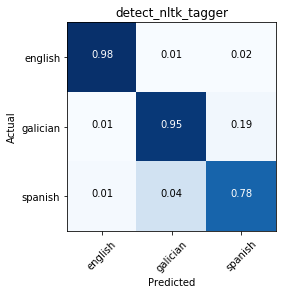

In [31]:
compute_accuracy_tokens(titles_sentences, detect_nltk_tagger)

In [33]:
plot_all_accuracies()

                          algorithm     accuracy                 
                               ----     ----                     
              detect_nltk_stopwords     0.8446666666666667       
                       detect_vocab     0.914                    
                 detect_nltk_tagger     0.904                    

                          algorithm     time                     
                               ----     ----                     
              detect_nltk_stopwords     0.09231209754943848      
                       detect_vocab     0.04699826240539551      
                 detect_nltk_tagger     0.2017529010772705       


# Langdetect
Port of Google’s (https://code.google.com/p/language-detection/) library (version from 03/03/2014) to Python

See: https://pypi.org/project/langdetect/
```bash
pip install langdetect
```
 
 
- Galician no available out of the box (https://code.google.com/archive/p/language-detection/wikis/LanguageList.wiki), but accept create new profiles
- The algorithm use a improved dataset extracted from Wikipedia, and a naive Bayes (see https://www.slideshare.net/shuyo/language-detection-library-for-java)

In order to create new profile , run:

```bash

git clone https://github.com/shuyo/language-detection.git
cd language-detection
wget https://dumps.wikimedia.org/glwiki/latest/glwiki-latest-abstract.xml.gz
java -jar lib/langdetect.jar --genprofile -d . gl
cp language-detection/profiles/gl /home/xurxo/.pyenv/versions/langdetect-survey/lib/python3.6/site-packages/langdetect/profiles 
```


In [34]:
from langdetect import detect, lang_detect_exception


def detect_langdetect(sentence):
    try:
        return iso_to_human[detect(sentence)]
    except (lang_detect_exception.LangDetectException, KeyError):
        return 'unknown'

In [35]:
print(detect_langdetect(english_text))
print(detect_langdetect(spanish_text))
print(detect_langdetect(galician_text))
print(detect_langdetect(portuguese_text))


english
spanish
galician
unknown


In [36]:
# very slow

# compute_accuracy_sentences(titles_sentences_small, detect_langdetect)

# Langid

https://github.com/saffsd/langid.py

```bash
pip install langid
```

Galician out of the box!

In [37]:
import langid
if include_pt:
    langid.set_languages(['es','en','gl','pt'])
else:
    langid.set_languages(['es','en','gl',])
langid.classify("This is a test")


def lang_id_detection(sentence):
    return iso_to_human[langid.classify(sentence)[0]]


In [38]:
print(lang_id_detection(english_text))
print(lang_id_detection(spanish_text))
print(lang_id_detection(galician_text))
print(lang_id_detection(portuguese_text))


english
spanish
galician
galician


lang_id_detection     Accuracy: 0.8846666666666667       Time: 0.9763045310974121


0.8846666666666667

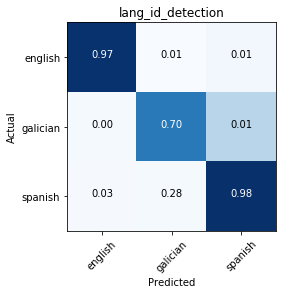

In [39]:

compute_accuracy_sentences(titles_sentences, lang_id_detection)

# Not valid solutions

## Gesslanguage
https://pypi.org/project/guess-language/

```bash
pip install guess_language-spirit
```

Based on guesslanguage.cpp by Jacob R Rideout for KDE which itself is based on Language::Guess by Maciej Ceglowski.

Detects over 60 languages - all languages listed in the trigrams directory plus Japanese, Chinese, Korean and Greek.

guess_language uses heuristics based on the character set and trigrams in a sample text to detect the language. It works better with longer samples.

It needs enchant spellchecking (a simple but comprehensive abstraction for dealing
with different spell checking libraries in a consistent way) in order to work with sentences with 20 words or less. You need the pyenchant wrapper, and the dictionaries of the languages. Enchant repo: https://github.com/AbiWord/enchant

```bash
sudo apt install aspell-pt aspell-gl-minimos aspell-es aspell-en aspell enchant
```


See https://bitbucket.org/spirit/guess_language to current python library version

In [208]:
from guess_language import guess_language

def guess_language_detection(sentence):
    return iso_to_human.get(guess_language(sentence),'unknow')

In [209]:
print(guess_language_detection(english_text))
print(guess_language_detection(spanish_text))
print(guess_language_detection('O periódico funcionou sempre como semanario, aínda que en diversos períodos viuse obrigado a saír quincenalmente, facendo en total 33 anos. En decembro de 2007 o periódico realizou unha importante reforma deseñística e de contidos[2]: Eiré, o daquela director, ascendía a conselleiro delegado, e as tarefas de dirección xornalística recaían en Manuel Veiga. Asemade, publicábase unha edición electrónica coordinada por César Lorenzo. Os problemas económicos, endémicos durante toda a vida desta cabeceira, comezaron a sucederse[3] ata que en agosto de 2010 a empresa editora, Promocións Culturais Galegas SA anunciou a suspensión de pagamentos e o peche do semanario en papel. A partir dese momento, continuou actualizándose a edición electrónica, que pechou definitivamente os seus contidos o 23 de setembro de 2011'))
print(guess_language_detection(portuguese_text))


english
spanish
spanish
portuguese


guess_language_detection     Accuracy: 0.7015       Time: 3.5386266708374023


0.7015

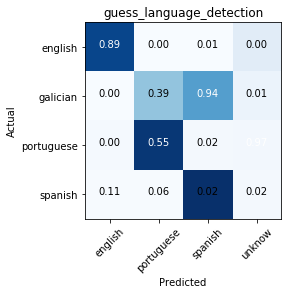

In [210]:

compute_accuracy_sentences(titles_sentences, guess_language_detection)


## language-detector
https://github.com/DanielJDufour/language-detector

```bash
pip install language-detector 
```

No galician either  portuguese languages available

In [211]:
from language_detector import detect_language




def guess_language_detection(sentence):
    lang = detect_language(sentence)
    return lang.lower() if lang else 'unknow'

In [212]:
print(guess_language_detection(english_text))
print(guess_language_detection(spanish_text))
print(guess_language_detection(galician_text))
print(guess_language_detection(portuguese_text))

english
spanish
spanish
french


guess_language_detection     Accuracy: 0.349       Time: 0.09827899932861328


0.349

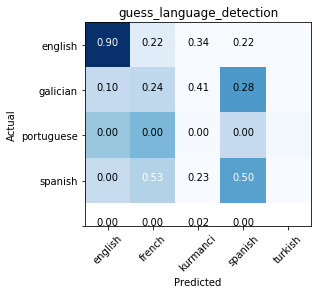

In [213]:
compute_accuracy_sentences(titles_sentences, guess_language_detection)

# polyglot
https://github.com/aboSamoor/polyglot / http://polyglot-nlp.com

A multilingual text (NLP) processing toolkit  by Rami Al-Rfou 

```bash
pip install polyglot pyicu  pycld2 morfessor
```

Polyglot uses  cld2 library, so I didn't test it here.


In [40]:
from polyglot.text import Text, Detector

    
def detect_with_polyglot (text):
    try:
        if detector.language.code in iso_to_human:
            return iso_to_human[Text(text).language.code]
        else:
            return 'unknow'
    except:
        return detect_vocab(word_tokenize(text))

In [41]:
print(detect_with_polyglot(english_text))
print(detect_with_polyglot(spanish_text))
print(detect_with_polyglot(galician_text))
print(detect_with_polyglot(portuguese_text))

english
spanish
galician
galician


detect_with_polyglot     Accuracy: 0.9186666666666666       Time: 0.7695493698120117


0.9186666666666666

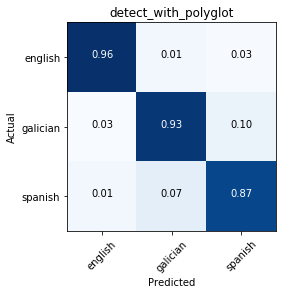

In [42]:
import warnings

warnings.filterwarnings("ignore")

compute_accuracy_sentences(titles_sentences, detect_with_polyglot)

In [43]:
plot_all_accuracies()

                          algorithm     accuracy                 
                               ----     ----                     
              detect_nltk_stopwords     0.8446666666666667       
                       detect_vocab     0.914                    
                 detect_nltk_tagger     0.904                    
                  lang_id_detection     0.8846666666666667       
               detect_with_polyglot     0.9186666666666666       

                          algorithm     time                     
                               ----     ----                     
              detect_nltk_stopwords     0.09231209754943848      
                       detect_vocab     0.04699826240539551      
                 detect_nltk_tagger     0.2017529010772705       
                  lang_id_detection     0.9763045310974121       
               detect_with_polyglot     0.7695493698120117       


# FastText: Learn a classifier based on n-grams embeddings

Directly copied from https://tech.people-doc.com/how-to-detect-western-language-with-python.html#Learn-a-classifier-based-on-n-grams-embeddings

More info abou the library FastText, by *Facebook*: https://fasttext.cc/

```bash
pip install cython
pip install pyfasttext sklearn scipy 
# optional 
pip install csygnals numpy
```

To create a galician corpus, we use the wikipedia. You can create a text version with Wikipedia Extractor. Download code  http://medialab.di.unipi.it/wiki/Wikipedia_Extractor . You can make some tweaks like include (or not) titles, sort articles, etc. The process takes 5 min. aprox.

```bash

$ git clone https://github.com/attardi/wikiextractor.git
$ cd wikiextractor
$ wget https://dumps.wikimedia.org/glwiki/latest/glwiki-latest-pages-articles.xml.bz2
$ bzip2 -d glwiki-latest-pages-articles.xml.bz2
$ ./WikiExtractor.py -o . -s --no-templates --min_text_length 150 --filter_disambig_pages -de gallery,timeline,noinclude  glwiki-latest-pages-articles.xml -it abbr,b,big --json -cb 250K
...
INFO: 414064	Pedersöre
INFO: Finished 3-process extraction of 149036 articles in 295.8s (503.8 art/s)

$  find . -name '*bz2' -exec bunzip2 -c {} \; >galician_wikipedia_text.json
$  rm -rf extracted
```







In [44]:
for lang, corpora in all_corpus.items():
    for corpus_name, corpus in corpora.items():
        print (f'{lang}, {corpus_name}, {len(corpus())}')
        

'deserializing from /home/xurxo/todo/tmp//corpus/en_brown.corpus'
english, en_brown, 981716
'deserializing from /home/xurxo/todo/tmp//corpus/en_wordnet.corpus'
english, en_wordnet, 77503
'deserializing from /home/xurxo/todo/tmp//corpus/en_europarl.corpus'
english, en_europarl, 494443
'deserializing from /home/xurxo/todo/tmp//corpus/sp_cess.corpus'
spanish, sp_cess, 155978
'deserializing from /home/xurxo/todo/tmp//corpus/sp_wordnet.corpus'
spanish, sp_wordnet, 22477
'deserializing from /home/xurxo/todo/tmp//corpus/sp_europarl.corpus'
spanish, sp_europarl, 548301
'deserializing from /home/xurxo/todo/tmp//corpus/gl_corga.corpus'
galician, gl_corga, 9801
'deserializing from /home/xurxo/todo/tmp//corpus/gl_wordnet.corpus'
galician, gl_wordnetl, 14154
'deserializing from /home/xurxo/todo/tmp//corpus/gl_wikipedia.corpus'
galician, gl_wikipedia, 348259


In [45]:
all_vocab = None

import gc
gc.collect()

7

In [46]:
from pyfasttext import FastText
from sklearn.model_selection import train_test_split
from nltk import ngrams
import os.path

from operator import itemgetter



def get_trigrams (copus_name, language, words, n):
    fname = '/home/xurxo/todo/tmp/fasttext/trigrams_' + copus_name 
    if not os.path.isfile(fname):
        partial_set = [(language, ' '.join(trigram)) for trigram in ngrams(words, 2) ]
        serialize_to_disk(fname, partial_set)
    else:
        partial_set = deserialize_from_disk(fname)
    return partial_set

                

def fasttext_predict_for_model(model, sentence):
    return model.predict([sentence+'\n'])[0][0]

class fasttext_predict:
    def __init__(self, model):
        self.model = model
        self.__name__ = 'fasttext_predict'
        
    def __call__(self, sentence):
        return fasttext_predict_for_model (self.model, sentence)
    


In [47]:
for language, corpora in all_corpus.items():
    for corpus_name, words in corpora.items():
        get_trigrams(corpus_name, language, words(), 2)


'deserializing from /home/xurxo/todo/tmp//corpus/en_brown.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_en_brown'
'deserializing from /home/xurxo/todo/tmp//corpus/en_wordnet.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_en_wordnet'
'deserializing from /home/xurxo/todo/tmp//corpus/en_europarl.corpus'
('deserializing from '
 '/home/xurxo/todo/tmp/fasttext/trigrams_en_europarl')
'deserializing from /home/xurxo/todo/tmp//corpus/sp_cess.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_sp_cess'
'deserializing from /home/xurxo/todo/tmp//corpus/sp_wordnet.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_sp_wordnet'
'deserializing from /home/xurxo/todo/tmp//corpus/sp_europarl.corpus'
('deserializing from '
 '/home/xurxo/todo/tmp/fasttext/trigrams_sp_europarl')
'deserializing from /home/xurxo/todo/tmp//corpus/gl_corga.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_gl_corga'
'deserializing from /home

In [48]:
import gc




def detect_fasttext (combo_name, doc_set, corpus_names):
        model_fname = f'{tmp_dir}/fasttext/model_fasttext_' + combo_name

        if not os.path.isfile(model_fname + '.vec'):
            pp.pprint ('creating trigrams for ' + combo_name)
            trigrams_set= []
            for (language, words) in doc_set:
                partial_set = get_trigrams(corpus_names[language], language, words(), 2)
                trigrams_set.extend(partial_set)

            #trigrams_set = [(language, ' '.join(trigram)) 
            #                for (language, words) in doc_set
            #                for trigram in ngrams(words, 2)] 
            # serialize_to_disk(trigram_fname, trigrams_set)

            train_set, test_set = train_test_split(trigrams_set, 
                                                   test_size = 0.30, 
                                                   random_state=0)

            pp.pprint ('generating train data for ' + combo_name)
            train_data_fname = f'{tmp_dir}/fasttext/train_data_fasttext_{combo_name}.txt'
            with open(train_data_fname, 'w') as f:
                for label, words in train_set:
                    f.write('__label__{} {}\n'.format(label, words))

            pp.pprint ('generating model for ' + combo_name)
            model = FastText()
            model.supervised(input=train_data_fname,
                         output=model_fname, 
                         epoch=10, lr=0.7, wordNgrams=2)

            # train accuracy
            labels, samples = np.split(np.array(train_set), 2, axis=1)
            print ('train accuracy:' + str ( (np.array(model.predict(samples.T[0])) == labels).sum() / len(train_set) ))
            # test accuracy
            labels, samples = np.split(np.array(test_set), 2, axis=1)
            print ('test accuracy:' + str ( (np.array(model.predict(samples.T[0])) == labels).sum() / len(test_set) ) )
        else:
            pp.pprint ('deserializing model for ' + combo_name)
            model = FastText(model_fname + '.bin')

        pp.pprint ('calculating accuracy for ' + combo_name)
        
        predictor = fasttext_predict (model)
        
        return compute_accuracy_sentences(titles_sentences, predictor, verbose=False) 
                    

'en_brown-sp_cess-gl_corga'
'deserializing model for en_brown-sp_cess-gl_corga'
'calculating accuracy for en_brown-sp_cess-gl_corga'
fasttext_predict     Accuracy: 0.7353333333333333       Time: 0.05538654327392578
'en_brown-sp_cess-gl_wordnetl'
'deserializing model for en_brown-sp_cess-gl_wordnetl'
'calculating accuracy for en_brown-sp_cess-gl_wordnetl'
fasttext_predict     Accuracy: 0.664       Time: 0.056349992752075195
'en_brown-sp_cess-gl_wikipedia'
'creating trigrams for en_brown-sp_cess-gl_wikipedia'
'deserializing from /home/xurxo/todo/tmp//corpus/en_brown.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_en_brown'
'deserializing from /home/xurxo/todo/tmp//corpus/sp_cess.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_sp_cess'
'deserializing from /home/xurxo/todo/tmp//corpus/gl_wikipedia.corpus'
('deserializing from '
 '/home/xurxo/todo/tmp/fasttext/trigrams_gl_wikipedia')
'generating train data for en_brown-sp_cess-gl_wikipedia'
'generating 

('deserializing from '
 '/home/xurxo/todo/tmp/fasttext/trigrams_en_europarl')
'deserializing from /home/xurxo/todo/tmp//corpus/sp_cess.corpus'
'deserializing from /home/xurxo/todo/tmp/fasttext/trigrams_sp_cess'
'deserializing from /home/xurxo/todo/tmp//corpus/gl_wikipedia.corpus'
('deserializing from '
 '/home/xurxo/todo/tmp/fasttext/trigrams_gl_wikipedia')
'generating train data for en_europarl-sp_cess-gl_wikipedia'
'generating model for en_europarl-sp_cess-gl_wikipedia'
train accuracy:0.9780838338771487
test accuracy:0.9479245937971456
'calculating accuracy for en_europarl-sp_cess-gl_wikipedia'
fasttext_predict     Accuracy: 0.9533333333333334       Time: 0.05119514465332031
'en_europarl-sp_wordnet-gl_corga'
'deserializing model for en_europarl-sp_wordnet-gl_corga'
'calculating accuracy for en_europarl-sp_wordnet-gl_corga'
fasttext_predict     Accuracy: 0.54       Time: 0.05325818061828613
'en_europarl-sp_wordnet-gl_wordnetl'
'deserializing model for en_europarl-sp_wordnet-gl_wordnet

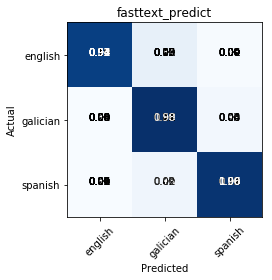

In [49]:

results = {}
best_combo = []
best_vocab_accuracy = 0
#for english_corpus, english_vocab in all_vocab['english'].items():
#    for spanish_corpus, spanish_vocab in all_vocab['spanish'].items():
#        for galician_corpus, galician_vocab in all_vocab['galician'].items():
#            for portuguese_corpus, portuguese_vocab in all_vocab['portuguese'].items():
combinations =  [[[lang, corpus_name, corpus] 
                  for corpus_name, corpus in corpora.items()] 
                 for lang, corpora in all_corpus.items()]
for combo in product(*combinations):
    gc.collect()
    try:
        doc_set = [(c[0],c[2]) for c in combo]
        corpus_names = {c[0]:c[1] for c in combo}
        combo_name = '-'.join([c[1] for c in combo])
        pp.pprint(combo_name)
        results[combo_name] =  detect_fasttext (combo_name, doc_set, corpus_names)
    #accuracy = compute_accuracy_tokens(titles_sentences, detect_vocab, plot_confusion=False) 
    #results[combo_name]  = accuracy
    #if (accuracy > best_vocab_accuracy):
    #    best_vocab_accuracy = accuracy
    #    best_combo = vocabs
    except Exception as e:
                    print (e) 
        

In [51]:


sorted(results.items(), key=itemgetter(1))

[('en_brown-sp_wordnet-gl_wordnetl', 0.37066666666666664),
 ('en_europarl-sp_wordnet-gl_wordnetl', 0.37333333333333335),
 ('en_wordnet-sp_wordnet-gl_wikipedia', 0.39066666666666666),
 ('en_wordnet-sp_europarl-gl_wordnetl', 0.464),
 ('en_wordnet-sp_europarl-gl_corga', 0.5206666666666667),
 ('en_europarl-sp_wordnet-gl_corga', 0.54),
 ('en_wordnet-sp_wordnet-gl_corga', 0.582),
 ('en_wordnet-sp_cess-gl_wordnetl', 0.59),
 ('en_wordnet-sp_cess-gl_corga', 0.592),
 ('en_brown-sp_wordnet-gl_corga', 0.6226666666666667),
 ('en_europarl-sp_wordnet-gl_wikipedia', 0.64),
 ('en_europarl-sp_europarl-gl_wordnetl', 0.6453333333333333),
 ('en_europarl-sp_cess-gl_wordnetl', 0.6526666666666666),
 ('en_brown-sp_wordnet-gl_wikipedia', 0.66),
 ('en_brown-sp_cess-gl_wordnetl', 0.664),
 ('en_brown-sp_europarl-gl_wordnetl', 0.6646666666666666),
 ('en_wordnet-sp_wordnet-gl_wordnetl', 0.6946666666666667),
 ('en_wordnet-sp_europarl-gl_wikipedia', 0.7),
 ('en_wordnet-sp_cess-gl_wikipedia', 0.7033333333333334),
 ('en

fasttext_predict     Accuracy: 0.972       Time: 0.0922701358795166


0.972

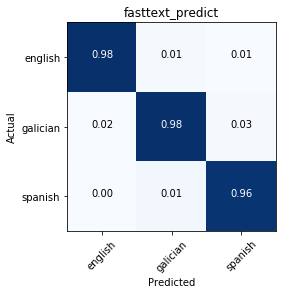

In [53]:
if include_pt:
    model_fname = f'{tmp_dir}/fasttext/model_fasttext_' + 'en_brown-sp_cess-gl_corga-pt_floresta'
else:
    model_fname = f'{tmp_dir}/fasttext/model_fasttext_' + 'en_brown-sp_europarl-gl_wikipedia'
model = FastText(model_fname + '.bin')
predictor = fasttext_predict (model)

compute_accuracy_sentences(titles_sentences, predictor, verbose=False) 
    

# textpipe

https://github.com/textpipe/textpipe

```bash
pip install textpipe
```

textpipe is a Python package for converting raw text in to clean, readable text and extracting metadata from that text. Its functionalities include transforming raw text into readable text by removing HTML tags and extracting metadata such as the number of words and named entities from the text.


detect_textpipe     Accuracy: 0.8466666666666667       Time: 0.5440225601196289


0.8466666666666667

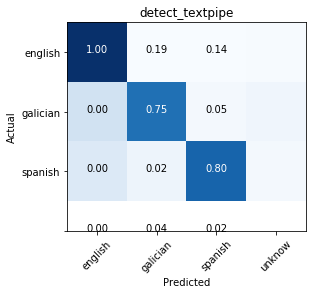

In [54]:
from textpipe import doc, pipeline

def detect_textpipe(sentence):
    document = doc.Doc(sentence)
    return iso_to_human.get(document.language,'unknow')
    


compute_accuracy_sentences (titles_sentences, detect_textpipe) 

In [56]:
plot_all_accuracies()

                          algorithm     accuracy                 
                               ----     ----                     
              detect_nltk_stopwords     0.8446666666666667       
                       detect_vocab     0.914                    
                 detect_nltk_tagger     0.904                    
                  lang_id_detection     0.8846666666666667       
               detect_with_polyglot     0.9186666666666666       
                   fasttext_predict     0.972                    
                    detect_textpipe     0.8466666666666667       

                          algorithm     time                     
                               ----     ----                     
              detect_nltk_stopwords     0.09231209754943848      
                       detect_vocab     0.04699826240539551      
                 detect_nltk_tagger     0.2017529010772705       
                  lang_id_detection     0.9763045310974121       
         

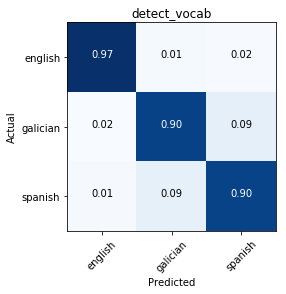

In [379]:
plot_confusion_matrix(confussion_matrices['detect_vocab'], title='detect_vocab')


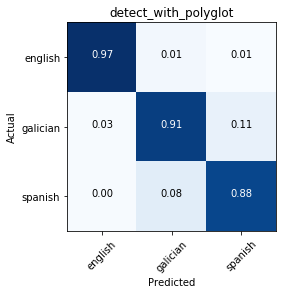

In [380]:
plot_confusion_matrix(confussion_matrices['detect_with_polyglot'], title='detect_with_polyglot')


In [57]:
titles_sentences.head()

,sentences,label,tokens,r_detect_nltk_stopwords,r_detect_vocab,r_detect_nltk_tagger,r_lang_id_detection,r_detect_with_polyglot,r_fasttext_predict,r_detect_textpipe
0,where would i go to improve my coding skills?,english,"[where, would, i, go, to, improve, my, coding,...",english,english,english,english,english,english,english
1,tips for a first time competitor,english,"[tips, for, a, first, time, competitor]",english,english,english,english,english,english,english
2,trueos to become core operating system,english,"[trueos, to, become, core, operating, system]",english,english,english,english,english,english,english
3,/howto/ssb/scuttlebot,english,[/howto/ssb/scuttlebot],english,english,galician,english,galician,english,english
4,how to overcome poverty by helping the unbanked?,english,"[how, to, overcome, poverty, by, helping, the,...",english,english,english,english,english,english,english


In [58]:

def compute_accuracy_vote(df, predictor, verbose=False, plot_confusion=True):
    columns = [c for c in list(titles_sentences.columns) if str(c).startswith('r_') and 'vote' not in c]
    print(columns)
    return compute_accuracy(df, predictor, columns, verbose, plot_confusion)

['r_detect_nltk_stopwords', 'r_detect_vocab', 'r_detect_nltk_tagger', 'r_lang_id_detection', 'r_detect_with_polyglot', 'r_fasttext_predict', 'r_detect_textpipe']
detect_vote     Accuracy: 0.97       Time: 0.16635370254516602


0.97

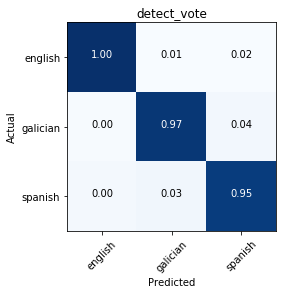

In [61]:
from collections import Counter

def detect_vote (array):
    C = Counter(array)
    #z.append(C)
    m = max(C.values())

    return random.choice([k for k, v in C.items() if v == m])
    
compute_accuracy_vote(titles_sentences, detect_vote)

In [164]:
titles_sentences.head()

,sentences,label,tokens,r_detect_nltk_stopwords,r_detect_glhandmade_stopwords,r_detect_unique_stopwords,r_predict_language_naive,r_detect_vocab,r_detect_nltk_tagger,r_lang_id_detection,r_guess_language_detection,r_detect_with_polyglot,r_fasttext_predict,r_detect_textpipe,r_detect_vote
0,where would i go to improve my coding skills?,english,"[where, would, i, go, to, improve, my, coding,...",english,english,english,english,english,english,english,english,english,english,english,english
1,tips for a first time competitor,english,"[tips, for, a, first, time, competitor]",portuguese,portuguese,english,portuguese,english,english,english,english,english,english,english,english
2,trueos to become core operating system,english,"[trueos, to, become, core, operating, system]",english,english,english,english,english,english,english,french,english,english,english,english
3,/howto/ssb/scuttlebot,english,[/howto/ssb/scuttlebot],english,galician,spanish,unknown,galician,english,english,english,portuguese,english,english,english
4,how to overcome poverty by helping the unbanked?,english,"[how, to, overcome, poverty, by, helping, the,...",english,english,english,english,english,english,english,english,english,english,english,english


In [62]:
accuracies

{'detect_nltk_stopwords': 0.8446666666666667,
 'detect_vocab': 0.914,
 'detect_nltk_tagger': 0.904,
 'lang_id_detection': 0.8846666666666667,
 'detect_with_polyglot': 0.9186666666666666,
 'fasttext_predict': 0.972,
 'detect_textpipe': 0.8466666666666667,
 'detect_vote': 0.97}

In [63]:
times

{'detect_nltk_stopwords': 0.09231209754943848,
 'detect_vocab': 0.04699826240539551,
 'detect_nltk_tagger': 0.2017529010772705,
 'lang_id_detection': 0.9763045310974121,
 'detect_with_polyglot': 0.7695493698120117,
 'fasttext_predict': 0.0922701358795166,
 'detect_textpipe': 0.5440225601196289,
 'detect_vote': 0.16635370254516602}